# Гарапко Даниил, группа 858641

# Лабораторная работа №8 “Выявление аномалий”

In [0]:
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from scipy.io import loadmat
from scipy.spatial import distance
import scipy.cluster.hierarchy as shc
import scipy.stats as sts
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import math
from PIL import Image

## Task 1

Набор данных ex8data1.mat представляет собой файл формата *.mat
(т.е. сохраненного из Matlab). Набор содержит две переменные X<sub>1</sub> и X<sub>2</sub> -
задержка в мс и пропускная способность в мб/c серверов. Среди серверов
необходимо выделить те, характеристики которых аномальные. Набор
разделен на обучающую выборку (X), которая не содержит меток классов, а
также валидационную (Xval, yval), на которой необходимо оценить качество
алгоритма выявления аномалий. В метках классов 0 обозначает отсутствие
аномалии, а 1, соответственно, ее наличие.

1. Загрузите данные ex8data1.mat из файла.

In [0]:
task1_file_name = "Data\Lab 8\ex8data1.mat"
mat = loadmat(task1_file_name)  # load mat-file
X = mat['X']
Xval = mat['Xval']
yval = mat['yval']
df_task1 = pd.DataFrame(X, columns=['delay', 'bandwidth'])

In [0]:
Xval.shape, yval.shape, X.shape

((307, 2), (307, 1), (307, 2))

2. Постройте график загруженных данных в виде диаграммы рассеяния.

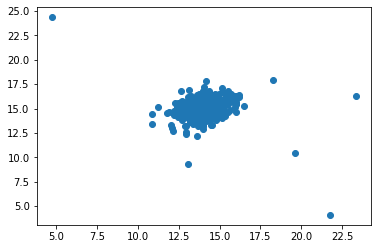

In [0]:
plt.scatter(X[:, 0], X[:, 1])
plt.show()

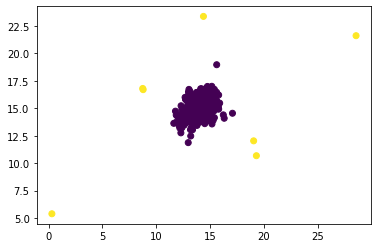

In [0]:
plt.scatter(Xval[:, 0], Xval[:, 1], c=yval[:,0])
plt.show()

3. Представьте данные в виде двух независимых нормально
распределенных случайных величин

In [0]:
mu = np.mean(X,axis=0)

In [0]:
sigma_2 = np.mean(np.square(X-mu),axis=0)

In [0]:
mu, sigma_2

(array([14.11222578, 14.99771051]), array([1.83263141, 1.70974533]))

4. Оцените параметры распределений случайных величин.

In [0]:
norm_rv_1 = sts.norm(mu[0], sigma_2[0]**.5)

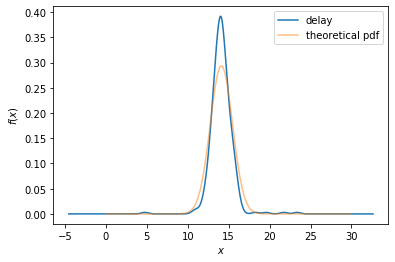

In [0]:
ax = df_task1[['delay']].plot(kind='density')

x = np.linspace(0,30,100)
pdf = norm_rv_1.pdf(x)
plt.plot(x, pdf, label='theoretical pdf', alpha=0.5)
plt.legend()
plt.ylabel('$f(x)$')
plt.xlabel('$x$')
plt.show()

In [0]:
norm_rv_2 = sts.norm(mu[1], sigma_2[1]**.5)

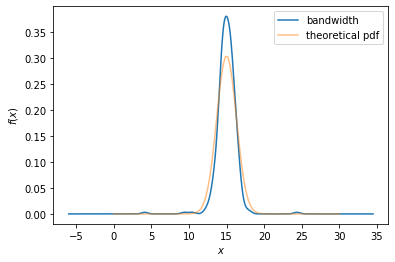

In [0]:
ax = df_task1[['bandwidth']].plot(kind='density')

x = np.linspace(0,30,100)
pdf = norm_rv_2.pdf(x)
plt.plot(x, pdf, label='theoretical pdf', alpha=0.5)
plt.legend()
plt.ylabel('$f(x)$')
plt.xlabel('$x$')
plt.show()

5. Постройте график плотности распределения получившейся случайной
величины в виде изолиний, совместив его с графиком из пункта 2.

In [0]:
xx, yy = np.meshgrid(np.arange(5,25, 0.1),
                     np.arange(5,25, 0.1))
Z = norm_rv_1.pdf(np.ravel(xx))*norm_rv_2.pdf(np.ravel(yy))
Z = Z.reshape(xx.shape)

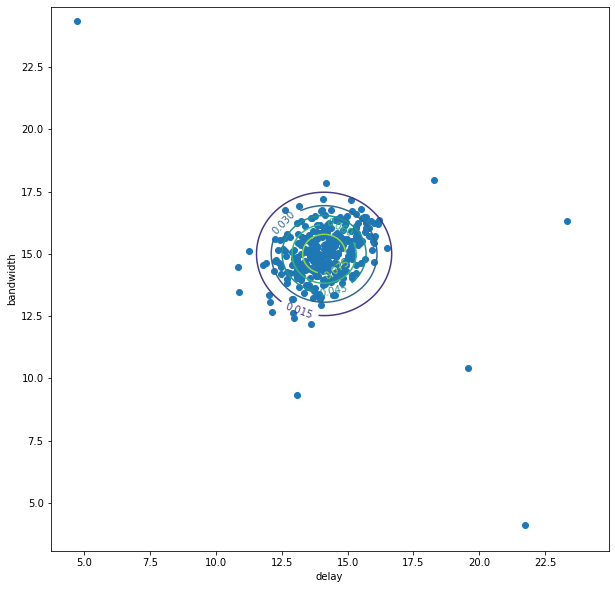

In [0]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1])
cp = plt.contour(xx, yy, Z)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('delay')
plt.ylabel('bandwidth')
plt.show()

6. Подберите значение порога для обнаружения аномалий на основе
валидационной выборки. В качестве метрики используйте F1-меру.


![image.png](attachment:image.png)

![image.png](attachment:image.png)

In [0]:
eps = 0.0001

In [0]:
Z = norm_rv_1.pdf(Xval[:, 0])*norm_rv_2.pdf(Xval[:, 1])

In [0]:
selected_pos_elements = np.in1d(np.where(Z>=eps),np.where(yval==0))
selected_neg_elements = np.in1d(np.where(Z<eps),np.where(yval==1))
true_positive = np.count_nonzero(selected_pos_elements)
false_positive = np.count_nonzero(selected_pos_elements==0)
false_negative = np.count_nonzero(selected_neg_elements==0)
precision = true_positive / (true_positive+false_positive)
recall = true_positive / (true_positive+false_negative)
f1_score = (2*precision*recall)/(precision+recall)
f1_score*100

99.66555183946488

7. Выделите аномальные наблюдения на графике из пункта 5 с учетом
выбранного порогового значения.


In [0]:
map_h2y = lambda p: 1 if p < eps else 0
map_h2y = np.vectorize(map_h2y)

In [0]:
Z_for_X = norm_rv_1.pdf(X[:, 0])*norm_rv_2.pdf(X[:, 1])
y = map_h2y(Z_for_X)

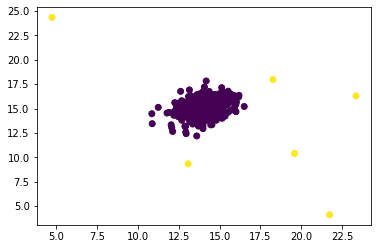

In [0]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

## Task 2

Набор данных ex8data2.mat представляет собой файл формата *.mat
(т.е. сохраненного из Matlab). Набор содержит 11-мерную переменную X -
координаты точек, среди которых необходимо выделить аномальные. Набор
разделен на обучающую выборку (X), которая не содержит меток классов, а
также валидационную (Xval, yval), на которой необходимо оценить качество
алгоритма выявления аномалий.

8. Загрузите данные ex8data2.mat из файла.


In [0]:
task2_file_name = "Data\Lab 8\ex8data2.mat"
mat = loadmat(task2_file_name)  # load mat-file
X = mat['X']
Xval = mat['Xval']
yval = mat['yval']

In [0]:
Xval.shape, yval.shape, X.shape

((100, 11), (100, 1), (1000, 11))

9. Представьте данные в виде 11-мерной нормально распределенной
случайной величины.

In [0]:
mu = np.mean(X,axis=0)
m, n= X.shape

In [0]:
mu, m, n

(array([  4.93940034,  -9.63726819,  13.81470749, -10.4644888 ,
         -7.95622922,  10.19950372,  -6.01940755,   7.96982896,
         -6.2531819 ,   2.32451289,   8.47372252]), 1000, 11)

In [0]:
covariance_matrix = (1/(m-1))*np.dot((X-mu).T,(X-mu))

p(x;μ,Σ)=1(2π)<sup>n/2</sup>|Σ|1/2exp(−1/2(x−μ)TΣ−1(x−μ))

In [0]:
p = lambda X: (1/((2*math.pi)**(n) * np.linalg.det(covariance_matrix))**0.5) * np.exp((-1/2)*np.dot(np.dot((X-mu),np.linalg.inv(covariance_matrix)).T, (X-mu))) 

In [0]:
var = sts.multivariate_normal(mean=mu, cov=covariance_matrix)

In [0]:
var.pdf([1,1,1,1,1,1,1,1,1,1,1])

2.5290821972595375e-18

10.Оцените параметры распределения случайной величины

In [0]:
pd.DataFrame(p)

,0,1,2,3,4,5,6,7,8,9,10
0,7.544947e-232,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15
1,6.423177e-15,7.544947e-232,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15
2,6.423177e-15,6.423177e-15,7.544947e-232,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15
3,6.423177e-15,6.423177e-15,6.423177e-15,7.544947e-232,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15
4,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,7.544947e-232,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15
5,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,7.544947e-232,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15
6,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,7.544947e-232,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15
7,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,7.544947e-232,6.423177e-15,6.423177e-15,6.423177e-15
8,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,7.544947e-232,6.423177e-15,6.423177e-15
9,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,6.423177e-15,7.544947e-232,6.423177e-15


In [0]:
pd.DataFrame(mu)

,0
0,4.939400
1,-9.637268
2,13.814707
3,-10.464489
4,-7.956229
5,10.199504
6,-6.019408
7,7.969829
8,-6.253182
9,2.324513


In [0]:
pd.DataFrame(covariance_matrix)

,0,1,2,3,4,5,6,7,8,9,10
0,61.035930,1.314583,0.693511,0.130364,4.681187,-0.532519,-3.382125,4.946758,-1.155293,3.916385,-2.906491
1,1.314583,53.258981,-2.226883,-4.610783,1.734714,3.082635,1.384834,7.520487,4.198534,-4.830286,7.722360
2,0.693511,-2.226883,58.574037,2.626325,3.311684,-3.391139,2.849118,2.177699,7.235789,5.894876,-2.849422
3,0.130364,-4.610783,2.626325,84.288326,1.907196,1.428353,3.766864,2.570716,-4.182472,1.914341,-1.232358
4,4.681187,1.734714,3.311684,1.907196,65.333926,1.184338,5.414941,-2.526312,0.747582,4.016777,-0.517578
5,-0.532519,3.082635,-3.391139,1.428353,1.184338,89.664542,2.258749,1.326746,-0.120596,-3.433440,1.275621
6,-3.382125,1.384834,2.849118,3.766864,5.414941,2.258749,55.689188,-1.626520,-1.568366,-1.464856,-5.358843
7,4.946758,7.520487,2.177699,2.570716,-2.526312,1.326746,-1.626520,87.249587,3.664037,-1.265500,2.366665
8,-1.155293,4.198534,7.235789,-4.182472,0.747582,-0.120596,-1.568366,3.664037,29.658927,-0.466670,2.345768
9,3.916385,-4.830286,5.894876,1.914341,4.016777,-3.433440,-1.464856,-1.265500,-0.466670,70.856061,-0.338301


11.Подберите значение порога для обнаружения аномалий на основе
валидационной выборки. В качестве метрики используйте F1-меру.

In [0]:
eps = 1e-20

In [0]:
# Z = var.pdf(Xval)
Z = p(Xval)

In [0]:
selected_pos_elements = np.in1d(np.where(Z>=eps),np.where(yval==0))
selected_neg_elements = np.in1d(np.where(Z<eps),np.where(yval==1))
true_positive = np.count_nonzero(selected_pos_elements)
false_positive = np.count_nonzero(selected_pos_elements==0)
false_negative = np.count_nonzero(selected_neg_elements==0)
precision = true_positive / (true_positive+false_positive)
recall = true_positive / (true_positive+false_negative)
f1_score = (2*precision*recall)/(precision+recall)
f1_score*100

90.09433962264151

12.Выделите аномальные наблюдения в обучающей выборке. Сколько их
было обнаружено? Какой был подобран порог?

In [0]:
map_h2y = lambda p: 1 if p < eps else 0
map_h2y = np.vectorize(map_h2y)

In [0]:
Z_for_X = var.pdf(X)
y = map_h2y(Z_for_X)

In [0]:
np.count_nonzero(y)

8